In [28]:
import numpy as np
from time import time
from scipy.linalg import cho_factor, cho_solve

from scipy.optimize.linesearch import scalar_search_wolfe2

class LineSearchTool(object):
    """
    Line search tool for adaptively tuning the step size of the algorithm.

    method : String containing 'Wolfe', 'Armijo' or 'Constant'
        Method of tuning step-size.
        Must be be one of the following strings:
            - 'Wolfe' -- enforce strong Wolfe conditions;
            - 'Armijo" -- adaptive Armijo rule;
            - 'Constant' -- constant step size.
    kwargs :
        Additional parameters of line_search method:

        If method == 'Wolfe':
            c1, c2 : Constants for strong Wolfe conditions
            alpha_0 : Starting point for the backtracking procedure
                to be used in Armijo method in case of failure of Wolfe method.
        If method == 'Armijo':
            c1 : Constant for Armijo rule
            alpha_0 : Starting point for the backtracking procedure.
        If method == 'Constant':
            c : The step size which is returned on every step.
    """
    def __init__(self, method='Armijo', **kwargs):
        self._method = method
        if self._method == 'Wolfe':
            self.c1 = kwargs.get('c1', 1e-4)
            self.c2 = kwargs.get('c2', 0.9)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Armijo':
            self.c1 = kwargs.get('c1', 1e-4)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Constant':
            self.c = kwargs.get('c', 1.0)
        else:
            raise ValueError('Unknown method {}'.format(method))

    @classmethod
    def from_dict(cls, options):
        if type(options) != dict:
            raise TypeError('LineSearchTool initializer must be of type dict')
        return cls(**options)

    def to_dict(self):
        return self.__dict__

    def line_search(self, oracle, x_k, d_k, previous_alpha=None):
        """
        Finds the step size alpha for a given starting point x_k
        and for a given search direction d_k that satisfies necessary
        conditions for phi(alpha) = oracle.func(x_k + alpha * d_k).

        Parameters
        ----------
        oracle : BaseSmoothOracle-descendant object
            Oracle with .func_directional() and .grad_directional() methods implemented for computing
            function values and its directional derivatives.
        x_k : np.array
            Starting point
        d_k : np.array
            Search direction
        previous_alpha : float or None
            Starting point to use instead of self.alpha_0 to keep the progress from
             previous steps. If None, self.alpha_0, is used as a starting point.

        Returns
        -------
        alpha : float or None if failure
            Chosen step size
        """
        # TODO: Implement line search procedures for Armijo, Wolfe and Constant steps.
        phi = lambda alpha: oracle.func_directional(x_k, d_k, alpha)
        derphi = lambda alpha: oracle.grad_directional(x_k, d_k, alpha)
        phi0 = phi(0)
        derphi0 = derphi(0)
        if self._method == 'Constant':
            alpha = self.c
        elif self._method == 'Armijo':
            alpha = self.alpha_0 if previous_alpha is None else previous_alpha
            derphi0 = derphi(0)
            while phi(alpha) > phi(0) + self.c1 * alpha * derphi0:
                alpha = alpha / 2
        elif self._method == 'Wolfe':
            alpha = scalar_search_wolfe2(phi, derphi, phi0, None, derphi0, c1=self.c1, c2=self.c2)
            alpha = alpha[0]
            if alpha is None:
                alpha = self.alpha_0 if previous_alpha is None else previous_alpha
                derphi0 = np.dot(oracle.grad(x_k), d_k)
                while phi(alpha) > phi(0) + self.c1 * alpha * derphi0:
                    alpha = alpha / 2
        return alpha


def get_line_search_tool(line_search_options=None):
    if line_search_options:
        if type(line_search_options) is LineSearchTool:
            return line_search_options
        else:
            return LineSearchTool.from_dict(line_search_options)
    else:
        return LineSearchTool()

C:\Users\Алим\AppData\Local\Temp\ipykernel_30956\1303496855.py:5: DeprecationWarning: Please use `scalar_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import scalar_search_wolfe2


In [42]:
import numpy as np
import scipy
from scipy.special import expit


class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """

    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')

    def hess(self, x):
        """
        Computes the Hessian matrix at point x.
        """
        raise NotImplementedError('Hessian oracle is not implemented.')
    
    def func_directional(self, x, d, alpha):
        """
        Computes phi(alpha) = f(x + alpha*d).
        """
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        """
        Computes phi'(alpha) = (f(x + alpha*d))'_{alpha}
        """
        return np.squeeze(self.grad(x + alpha * d).dot(d))

   
class BarrierOracle(BaseSmoothOracle):
    
    def __init__(self, A: np.ndarray, b: np.ndarray, regcoef: float, t: float):
        self.A = A
        self.b = b

        self.regcoef = regcoef
        self.t = t

        self.matvec_Ax = lambda x: A @ x
        self.matvec_ATx = lambda x: A.T @ x

    def antider_func(self, pt: np.ndarray):
        x, u = np.array_split(pt, 2)
        return 1 / 2 * np.linalg.norm(self.matvec_Ax(x) - self.b) ** 2 + self.regcoef * np.sum(u)

    def func(self, pt: np.ndarray):
        x, u = np.array_split(pt, 2)
        up, um = np.log(u + x), np.log(u - x)
        return self.t * self.antider_func(pt) - np.sum(up + um)
    
    def grad(self, pt: np.ndarray):
        x, u = np.array_split(pt, 2)
        up, um = 1 / (u + x), 1 / (u - x)
        grad_func_x = self.t * self.matvec_ATx(self.matvec_Ax(x) - self.b) - up + um
        grad_func_u = self.t * self.regcoef * np.ones(len(u))
        return np.append(grad_func_x, grad_func_u)
    
    def hess(self, pt: np.ndarray):
        x, u = np.array_split(pt, 2)
        up, um = 1 / ((u + x) ** 2), 1 / ((u - x) ** 2)
        sm = up + um
        raz = up - um
        hess_func_u = np.diag(sm)
        hess_func_x = self.t * self.A.T @ self.A + np.diag(sm)
        hess_func_xu = np.diag(raz)
        return np.concatenate(
            (np.concatenate((hess_func_x, hess_func_xu), axis=1), 
             np.concatenate((hess_func_xu, hess_func_u), axis=1)), axis=0)


def lasso_duality_gap(x, Ax_b, ATAx_b, b, regcoef):
    """
    Estimates f(x) - f* via duality gap for 
        f(x) := 0.5 * ||Ax - b||_2^2 + regcoef * ||x||_1.
    """
    # TODO: implement.
    nrm = np.linalg.norm(ATAx_b, ord=np.inf)
    mu = np.min([1., regcoef / nrm]) * Ax_b
    if nrm < 1e-5:
        mu = Ax_b        
    nu = 1 / 2 * np.linalg.norm(Ax_b) ** 2 + regcoef * np.linalg.norm(x, 1) + 1 / 2 * np.linalg.norm(mu) ** 2 + b @ mu
    return nu

In [30]:
from collections import defaultdict
import numpy as np
from numpy.linalg import norm, solve
from numpy.linalg import LinAlgError
from time import time
from datetime import datetime
from scipy.linalg import cho_factor, cho_solve


def barrier_method_lasso(A, b, reg_coef, x_0, u_0, tolerance=1e-5, 
                         tolerance_inner=1e-8, max_iter=100, 
                         max_iter_inner=20, t_0=1, gamma=10, 
                         c1=1e-4, lassodualitygap=None,
                         trace=False, display=False):
    """
    Log-barrier method for solving the problem:
        minimize    f(x, u) := 1/2 * ||Ax - b||_2^2 + reg_coef * \sum_i u_i
        subject to  -u_i <= x_i <= u_i.

    The method constructs the following barrier-approximation of the problem:
        phi_t(x, u) := t * f(x, u) - sum_i( log(u_i + x_i) + log(u_i - x_i) )
    and minimize it as unconstrained problem by Newton's method.

    In the outer loop `t` is increased and we have a sequence of approximations
        { phi_t(x, u) } and solutions { (x_t, u_t)^{*} } which converges in `t`
    to the solution of the original problem.

    Parameters
    ----------
    A : np.array
        Feature matrix for the regression problem.
    b : np.array
        Given vector of responses.
    reg_coef : float
        Regularization coefficient.
    x_0 : np.array
        Starting value for x in optimization algorithm.
    u_0 : np.array
        Starting value for u in optimization algorithm.
    tolerance : float
        Epsilon value for the outer loop stopping criterion:
        Stop the outer loop (which iterates over `k`) when
            `duality_gap(x_k) <= tolerance`
    tolerance_inner : float
        Epsilon value for the inner loop stopping criterion.
        Stop the inner loop (which iterates over `l`) when
            `|| \nabla phi_t(x_k^l) ||_2^2 <= tolerance_inner * \| \nabla \phi_t(x_k) \|_2^2 `
    max_iter : int
        Maximum number of iterations for interior point method.
    max_iter_inner : int
        Maximum number of iterations for inner Newton's method.
    t_0 : float
        Starting value for `t`.
    gamma : float
        Multiplier for changing `t` during the iterations:
        t_{k + 1} = gamma * t_k.
    c1 : float
        Armijo's constant for line search in Newton's method.
    lasso_duality_gap : callable object or None.
        If calable the signature is lasso_duality_gap(x, Ax_b, ATAx_b, b, regcoef)
        Returns duality gap value for esimating the progress of method.
    trace : bool
        If True, the progress information is appended into history dictionary 
        during training. Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format is up to a student and is not checked in any way.

    Returns
    -------
    (x_star, u_star) : tuple of np.array
        The point found by the optimization procedure.
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every **outer** iteration of the algorithm
            - history['duality_gap'] : list of duality gaps
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2
    """
    # TODO: implement.
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    u_k = np.copy(u_0)
    t_k = t_0

    if display:
        print('Optimization debug information')
    times_0 = time()

    ldg_func = lassodualitygap if lassodualitygap is not None else lasso_duality_gap 
    print(A.shape, x_0.shape, b.shape)
    Ax_b = lambda y: A @ y - b
    ATAx_b = lambda y: A.T @ (A @ y - b) 
    ldg = lambda a: ldg_func(a, Ax_b(a), ATAx_b(a), b, reg_coef)
    line_search_options = {'method': 'Armijo', 'c1': c1}
    oracle = BarrierOracle(A, b, reg_coef, t_0)
    ldg_k = ldg(x_k)
    times_k = time() - times_0
    if trace:
        history['func'].append([oracle.antider_func(np.concatenate([x_k, u_k]))])
        history['time'].append([times_k])
        history['duality_gap'].append([ldg_k])
        if x_k.size <= 2:
            history['x'].append([x_k])

    for _ in range(max_iter):

        if ldg_k < tolerance:
            return (x_k, u_k), 'success', history
        
        oracle.t = t_k
        x_newton, mes_newton, _ = newton(oracle, np.concatenate([x_k, u_k]), 
                                         tolerance_inner, max_iter_inner, 
                                         line_search_options)
        x_k, u_k = np.array_split(x_newton, 2)
        if mes_newton == 'computational_error':
            return (x_k, u_k), 'computational_error', history

        t_k *= gamma
        ldg_k = ldg(x_k)
        times_k = time() - times_0
        if trace:
            history['func'].append([oracle.antider_func(np.concatenate([x_k, u_k]))])
            history['time'].append([times_k])
            history['duality_gap'].append([ldg_k])
            if x_k.size <= 2:
                history['x'].append([x_k])

        
    if ldg_k < tolerance:
        return (x_k, u_k), 'success', history
    
    return (x_k, u_k), 'iterations_exceeded', history


def optimal_alpha(vecs: np.ndarray, grads: np.ndarray):
    """
    Compute minimum value of alpha for linear search
    """

    x, u = np.split(vecs, 2)
    grad_x, grad_u = np.split(grads, 2)

    als = np.array([1.])
    theta = 0.99

    mask1 = grad_x > grad_u
    mask2 = grad_x < -grad_u

    als = np.append(als, theta * (u[mask1] - x[mask1]) / (grad_x[mask1] - grad_u[mask1]))
    als = np.append(als, theta * (x[mask2] + u[mask2]) / (-grad_x[mask2] - grad_u[mask2]))

    return np.min(als)


def newton(oracle, x_0, tolerance=1e-5, max_iter=100, line_search_options=None, trace=False, display=False):
    """
    Newton's optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. If the Hessian
        returned by the oracle is not positive-definite method stops with message="newton_direction_error"
    x_0 : np.array
        Starting point for optimization algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'newton_direction_error': in case of failure of solving linear system with Hessian matrix (e.g. non-invertible matrix).
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1.0})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)

    if display:
        print('Optimization debug information')

    times_0 = time()

    grad_k = lambda t: oracle.grad(t)
    func_k = lambda t: oracle.func(t)
    grad_0 = grad_k(x_0)
    times_k = time() - times_0
    if trace:
      history['time'] = [times_k]
      history['func'] = [func_k(x_k)]
      history['grad_norm'] = [np.linalg.norm(grad_0)]
      if x_k.size <= 2:
        history['x'] = [x_k]

    alpha0 = 1
    for _ in range(max_iter):
        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history
        try:
            grad = grad_k(x_k)
            hess = oracle.hess(x_k)
            d_k = cho_solve((cho_factor(hess)), -grad)
        except LinAlgError:
            return x_k, 'newton_direction_error', history

        if not (np.all(np.isfinite(x_k)) and np.all(np.isfinite(d_k))):
            return x_k, 'computational_error', history

        alpha = line_search_tool.line_search(oracle=oracle, x_k=x_k, d_k=d_k, previous_alpha=optimal_alpha(x_k, d_k))
        x_k = x_k + alpha * d_k
        times = time() - times_0
        if trace:
          history['time'].append(times)
          history['func'].append(func_k(x_k))
          history['grad_norm'].append(np.linalg.norm(grad_k(x_k)))
          if x_k.size <= 2:
              history['x'].append(x_k)

        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history

    return x_k, 'iterations_exceeded', history

### 1 эксперимент

(100, 70) (70,) (100,)
iterations_exceeded
(100, 70) (70,) (100,)


C:\Users\Алим\AppData\Local\Temp\ipykernel_29024\195609464.py:60: RuntimeWarning: divide by zero encountered in log
  up, um = np.log(u + x), np.log(u - x)


iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded


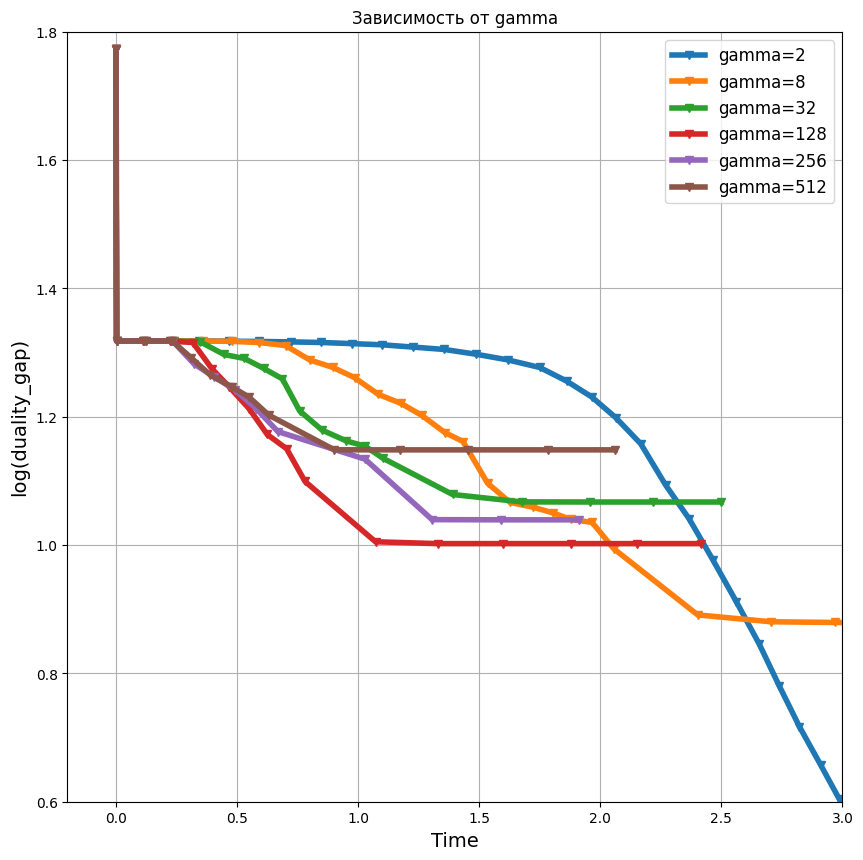

(100, 70) (70,) (100,)
(100, 70) (70,) (100,)
(100, 70) (70,) (100,)
(100, 70) (70,) (100,)
(100, 70) (70,) (100,)
(100, 70) (70,) (100,)


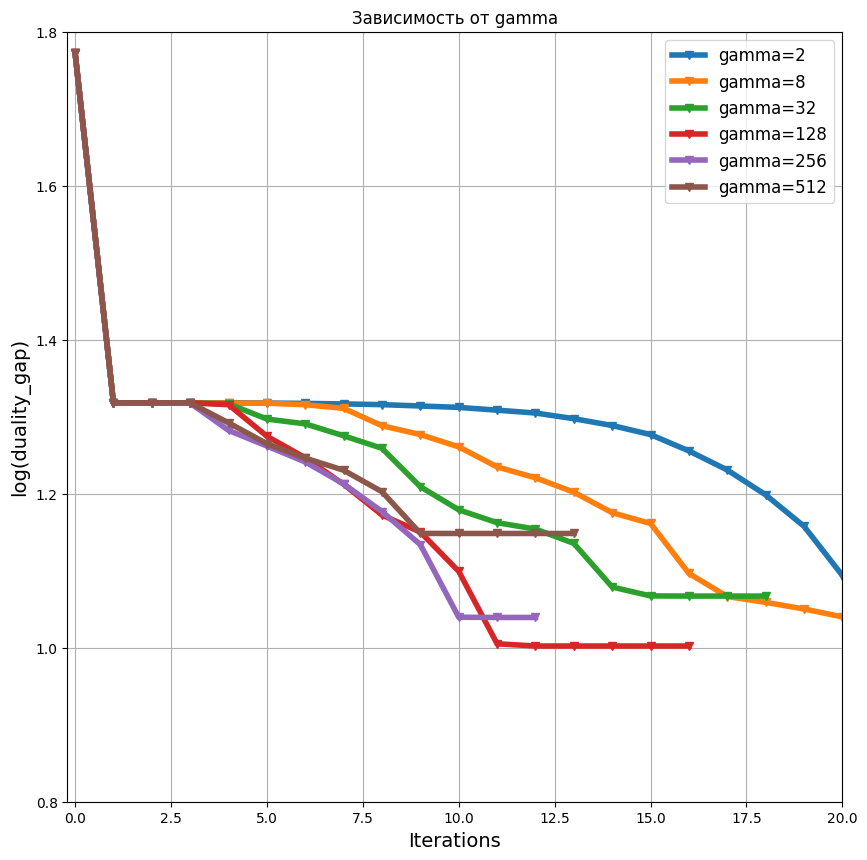

In [9]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)
m = 100
n = 70
A = np.random.randn(m, n)
b = np.random.randn(m)
regcoef = 1e-5

x_0 = np.zeros(n)
u_0 = np.array([10] * n)

gamma = [2, 8, 32, 128, 256, 512]

# График зависимости от времени
plt.figure(figsize=(10, 10))
for gm in gamma:
    _, _, history = barrier_method_lasso(A, b, regcoef, x_0, u_0, gamma=gm, trace=True, max_iter=50)
    plt.plot(history['time'][:len(np.unique(history['duality_gap']))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'gamma={gm}', linewidth=4, marker='v')
plt.title('Зависимость от gamma')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.ylim(0.6, 1.8)
plt.xlim(-0.2, 3)
plt.grid(True)
plt.show()

# График зависимости от номера итерации
plt.figure(figsize=(10, 10))
for gm in gamma:
    _, _, history = barrier_method_lasso(A, b, regcoef, x_0, u_0, gamma=gm, trace=True, max_iter=50)
    plt.plot([i for i in range(len(np.unique(history['duality_gap']) + 1))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'gamma={gm}', linewidth=4, marker='v')
plt.title('Зависимость от gamma')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.ylim(0.8, 1.8)
plt.xlim(-0.2, 20)
plt.grid(True)
plt.show()

(100, 70) (70,) (100,)


C:\Users\Алим\AppData\Local\Temp\ipykernel_29024\195609464.py:60: RuntimeWarning: divide by zero encountered in log
  up, um = np.log(u + x), np.log(u - x)


iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded
(100, 70) (70,) (100,)
iterations_exceeded


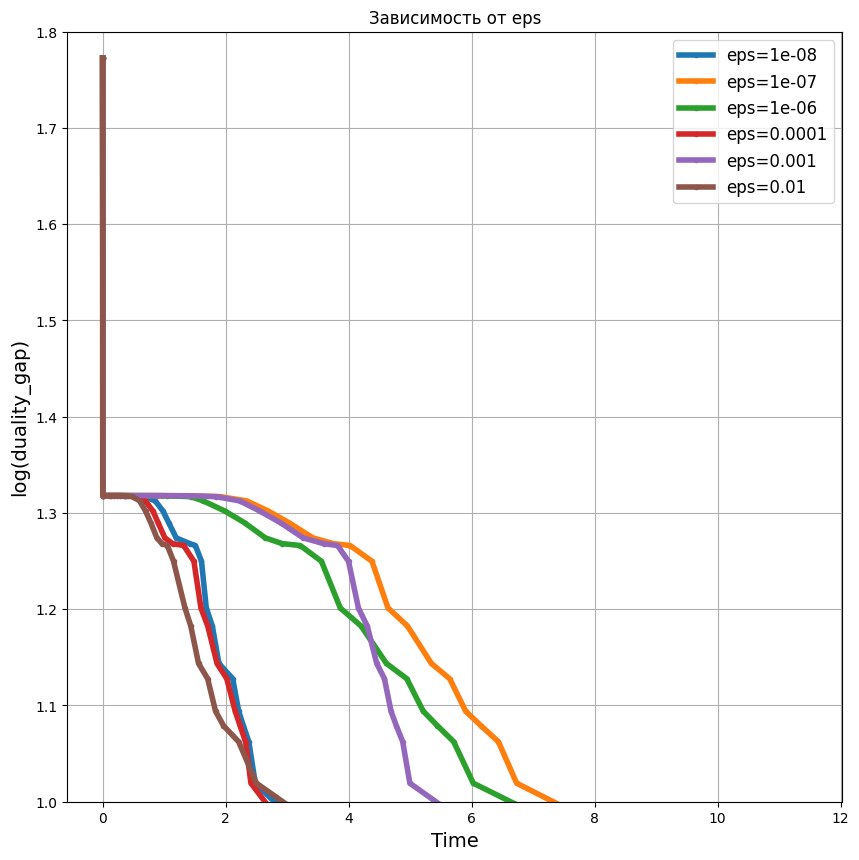

(100, 70) (70,) (100,)
(100, 70) (70,) (100,)
(100, 70) (70,) (100,)
(100, 70) (70,) (100,)
(100, 70) (70,) (100,)
(100, 70) (70,) (100,)


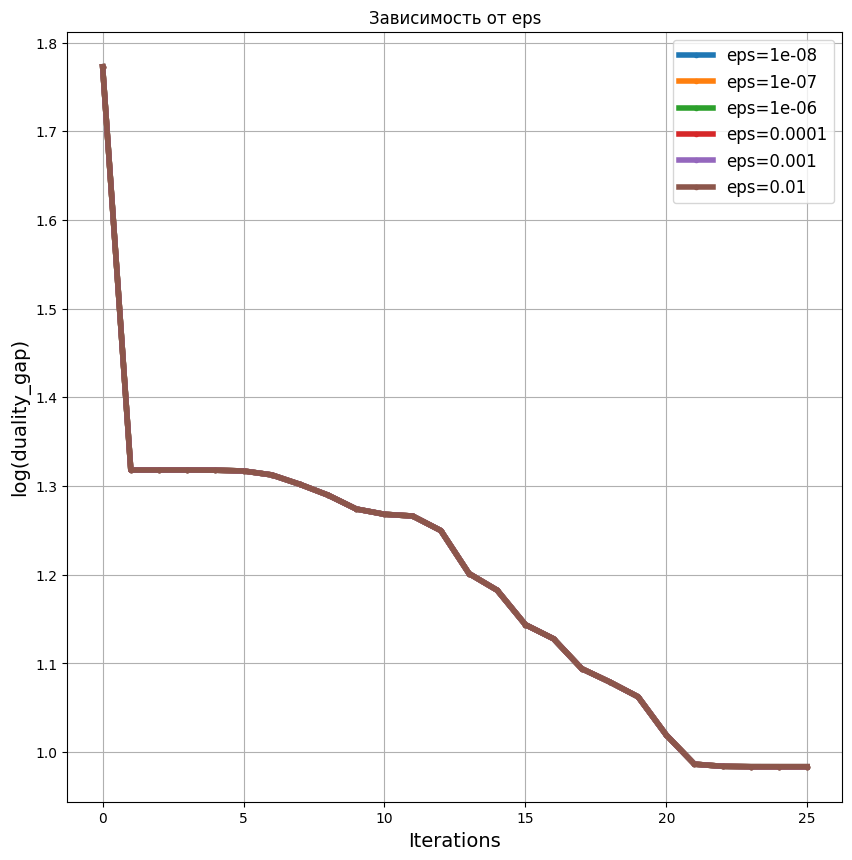

In [19]:
eps = [1e-8, 1e-7, 1e-6, 1e-4, 1e-3, 1e-2]

# График зависимости от времени
plt.figure(figsize=(10, 10))
for ep in eps:
    _, _, history = barrier_method_lasso(A, b, regcoef, x_0, u_0, tolerance_inner=ep, trace=True, max_iter=50)
    plt.plot(history['time'][:len(np.unique(history['duality_gap']))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'eps={ep}', linewidth=4, marker='.')
plt.title('Зависимость от eps')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.ylim(1, 1.8)
plt.grid(True)
plt.show()

# График зависимости от номера итерации
plt.figure(figsize=(10, 10))
for ep in eps:
    _, _, history = barrier_method_lasso(A, b, regcoef, x_0, u_0, tolerance_inner=ep, trace=True, max_iter=50)
    plt.plot([i for i in range(len(np.unique(history['duality_gap']) + 1))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'eps={ep}', linewidth=4, marker='.')
plt.title('Зависимость от eps')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.grid(True)
plt.show()

### 2 эксперимент

(200, 1) (1,) (200,)


C:\Users\Алим\AppData\Local\Temp\ipykernel_29024\195609464.py:60: RuntimeWarning: divide by zero encountered in log
  up, um = np.log(u + x), np.log(u - x)


(200, 2) (2,) (200,)
(200, 4) (4,) (200,)
(200, 8) (8,) (200,)
(200, 16) (16,) (200,)
(200, 32) (32,) (200,)
(200, 64) (64,) (200,)
(200, 128) (128,) (200,)


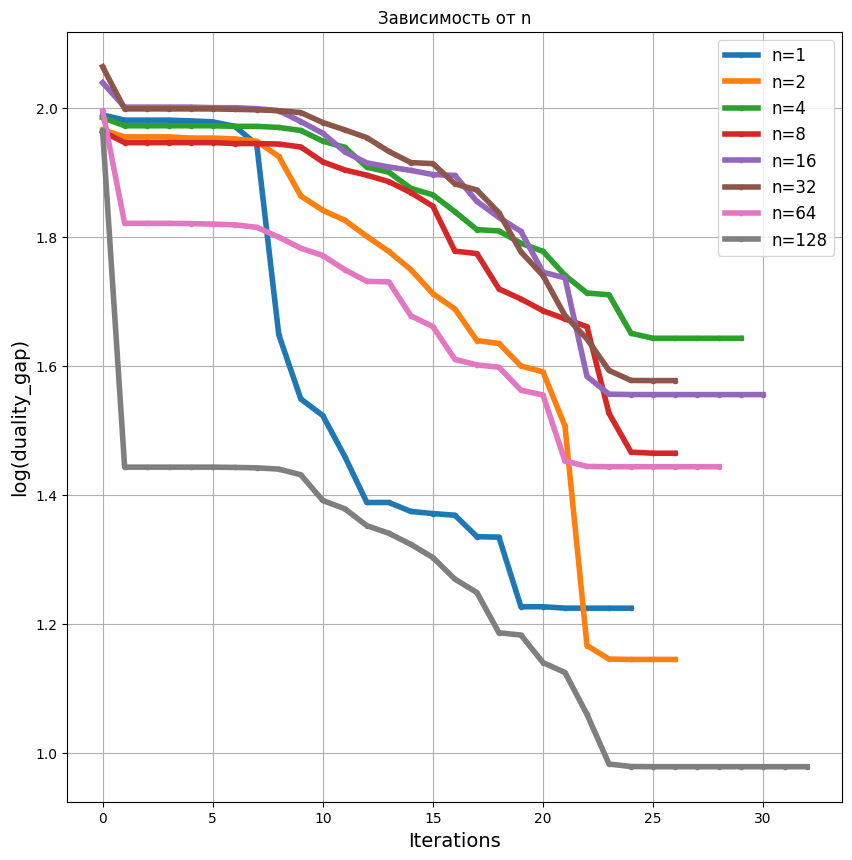

In [25]:
np.random.seed(42)
m = 200
n_ax = [2 ** i for i in range(8)]

# График зависимости от времени
plt.figure(figsize=(10, 10))
for n in n_ax:
    A = np.random.randn(m, n)
    b = np.random.randn(m)
    x_0 = np.zeros(n)
    u_0 = np.array([10] * n)
    _, _, history = barrier_method_lasso(A, b, regcoef, x_0, u_0, trace=True, max_iter=50)
    plt.plot(history['time'][:len(np.unique(history['duality_gap']))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'n={n}', linewidth=4, marker='v')
plt.title('Зависимость от n')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.grid(True)
plt.show()

# График зависимости от номера итерации
plt.figure(figsize=(10, 10))
for n in n_ax:
    A = np.random.randn(m, n)
    b = np.random.randn(m)
    x_0 = np.zeros(n)
    u_0 = np.array([10] * n)
    _, _, history = barrier_method_lasso(A, b, regcoef, x_0, u_0, trace=True, max_iter=50)
    plt.plot([i for i in range(len(np.unique(history['duality_gap']) + 1))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'n={n}', linewidth=4, marker='.')
plt.title('Зависимость от n')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.grid(True)
plt.show()

(10, 300) (300,) (10,)
(100, 300) (300,) (100,)
(300, 300) (300,) (300,)


C:\Users\Алим\AppData\Local\Temp\ipykernel_34732\195609464.py:60: RuntimeWarning: divide by zero encountered in log
  up, um = np.log(u + x), np.log(u - x)


(500, 300) (300,) (500,)


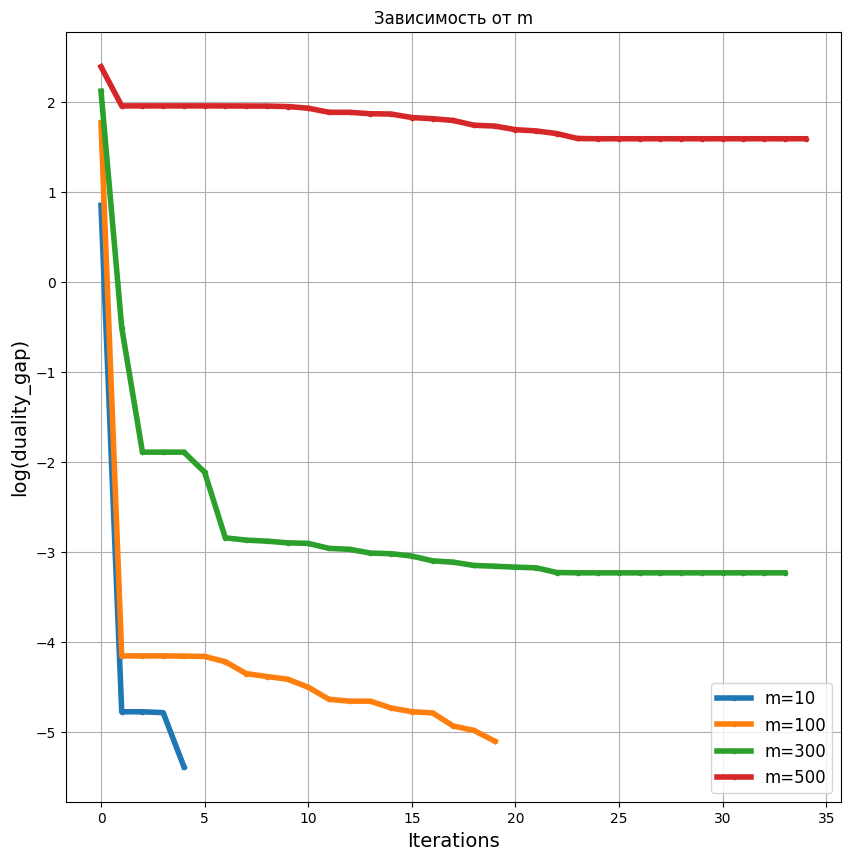

In [9]:
np.random.seed(42)
n = 300
m_ax = [10, 100, 300, 500]

# График зависимости от времени
plt.figure(figsize=(10, 10))
for m in m_ax:
    A = np.random.randn(m, n)
    b = np.random.randn(m)
    x_0 = np.zeros(n)
    u_0 = np.array([10] * n)
    _, _, history = barrier_method_lasso(A, b, regcoef, x_0, u_0, trace=True, max_iter=50)
    plt.plot(history['time'][:len(np.unique(history['duality_gap']))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'm={m}', linewidth=4, marker='v')
plt.title('Зависимость от m')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.grid(True)
plt.show()

# График зависимости от номера итерации
plt.figure(figsize=(10, 10))
for m in m_ax:
    A = np.random.randn(m, n)
    b = np.random.randn(m)
    x_0 = np.zeros(n)
    u_0 = np.array([10] * n)
    _, _, history = barrier_method_lasso(A, b, regcoef, x_0, u_0, trace=True, max_iter=50)
    plt.plot([i for i in range(len(np.unique(history['duality_gap']) + 1))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'm={m}', linewidth=4, marker='.')
plt.title('Зависимость от m')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.grid(True)
plt.show()

(50, 70) (70,) (50,)
(50, 70) (70,) (50,)
(50, 70) (70,) (50,)


C:\Users\Алим\AppData\Local\Temp\ipykernel_30956\2351001187.py:60: RuntimeWarning: divide by zero encountered in log
  up, um = np.log(u + x), np.log(u - x)


(50, 70) (70,) (50,)
(50, 70) (70,) (50,)
(50, 70) (70,) (50,)


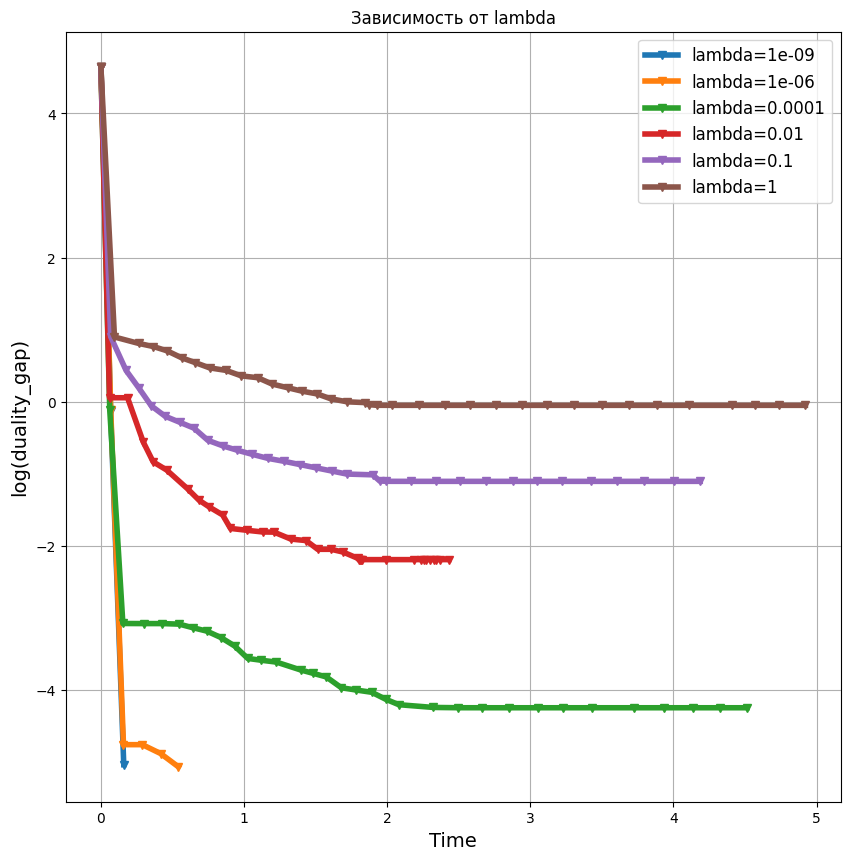

(50, 70) (70,) (50,)
(50, 70) (70,) (50,)
(50, 70) (70,) (50,)
(50, 70) (70,) (50,)
(50, 70) (70,) (50,)
(50, 70) (70,) (50,)


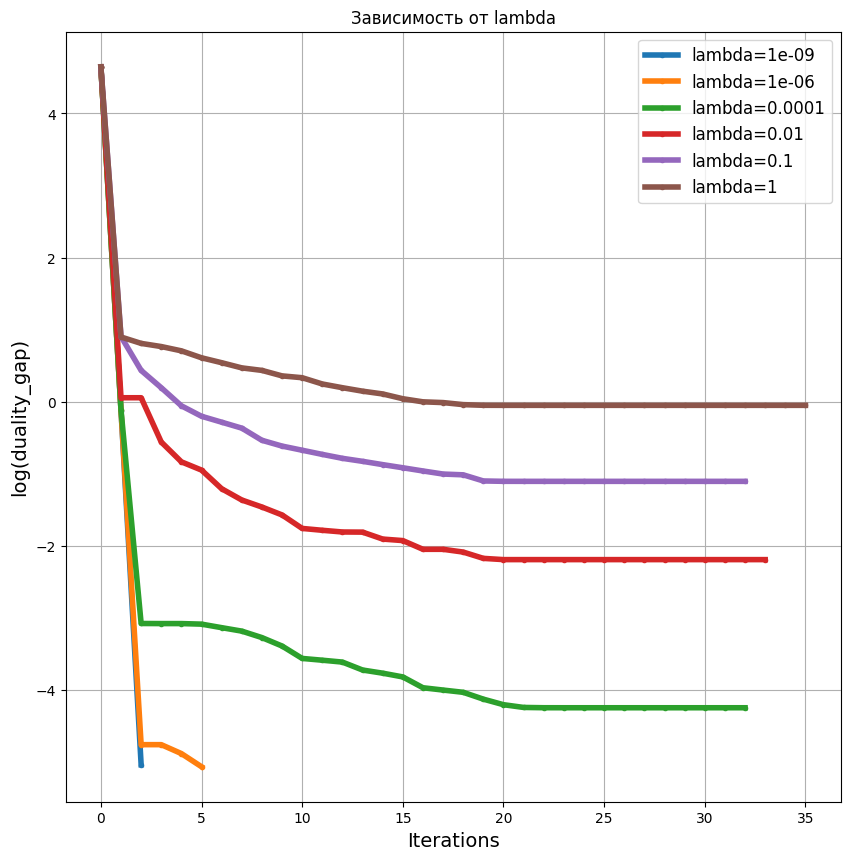

In [43]:
np.random.seed(100)
n = 70
m = 50
A = np.random.randn(m, n)
b = np.random.randn(m)
x_0 = np.array([5] * n)
u_0 = np.array([10] * n)
lambdas = [1e-9, 1e-6, 1e-4, 1e-2, 1e-1, 1]

# График зависимости от времени
plt.figure(figsize=(10, 10))
for lambda_ in lambdas:
    _, _, history = barrier_method_lasso(A, b, lambda_, x_0, u_0, trace=True, max_iter=50)
    plt.plot(history['time'][:len(np.unique(history['duality_gap']))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'lambda={lambda_}', linewidth=4, marker='v')
plt.title('Зависимость от lambda')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
# plt.ylim(1, 1.8)
# plt.xlim(-0.1, 2)
plt.grid(True)
plt.show()

# График зависимости от номера итерации
plt.figure(figsize=(10, 10))
for lambda_ in lambdas:
    _, _, history = barrier_method_lasso(A, b, lambda_, x_0, u_0, trace=True, max_iter=50)
    plt.plot([i for i in range(len(np.unique(history['duality_gap']) + 1))], np.log10(np.unique(history['duality_gap'])[::-1]), label=f'lambda={lambda_}', linewidth=4, marker='.')
plt.title('Зависимость от lambda')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('log(duality_gap)', fontsize=14)
plt.grid(True)
plt.show()